In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import functools
import scipy

# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, build_cov_mat, lognormpdf, plot_bivariate_gauss, eval_func_on_grid

def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

The Metropolis-Hastings variants of MCMC algorithms rely on an accept-reject probability. Specifically, given a proposal PDF (could be un-normalized) $q$, the current sample $x^{(k)}$ and a proposed sample $y$, the acceptance probability is
\begin{equation}
a(x^{(k)}, y) = \min \left\{ \frac{f_X(y)}{f_X(x^{(k)})} \frac{q(x^{(k)} \mid y)}{q(y \mid x^{(k)})}, \  1 \right\}
\end{equation}

In [127]:
def mh_acceptance_prob(current_target_logpdf,proposed_target_logpdf, current_sample, proposed_sample, proposal_func):
    """Compute the metropolis-hastings accept-reject probability
    
    Inputs
    ------
    current_target_logpdf : float, logpdf at the current sample in the chain f_X(x^{(k)})
    proposed_target_logpdf : float, logpdf at the proposed sample in the chain
    current_sample : (d, ), current sample
    proposed_sample : (d, ), proposed sample
    proposal_func: f(x, y) callable that gives the log probability of y given x
    
    Returns
    -------
    acceptance probability
    """
    
#     prop_reverse = proposal_func(proposed_sample, current_sample)
#     prop_forward = proposal_func(current_sample, proposed_sample)
    prop_reverse = proposal_func(proposed_sample, current_sample)
    prop_forward = proposal_func(current_sample, proposed_sample)
    check = proposed_target_logpdf - current_target_logpdf + prop_reverse - prop_forward
    if check < 0:
        return np.exp(check)
    else:
        return 1    
    
def mh_acceptance_prob_2(current_target_logpdf,proposed2_target_logpdf, current_sample, proposed1_sample, proposed2_sample, proposal1_func, proposal2_func, a1, a2):
    """Compute the metropolis-hastings accept-reject probability
    
    Inputs
    ------
    current_target_logpdf : float, logpdf at the current sample in the chain f_X(x^{(k)})
    proposed_target_logpdf : float, logpdf at the proposed sample in the chain
    current_sample : (d, ), current sample
    proposed_sample : (d, ), proposed sample
    proposal_func: f(x, y) callable that gives the log probability of y given x
    
    Returns
    -------
    acceptance probability
    """
    
    prop_reverse = proposal1_func(proposed1_sample, proposed2_sample)  #numerator
    prop_forward = proposal1_func(proposed1_sample, current_sample)  #denominator
    
    prop2_reverse = proposal2_func(current_sample, proposed2_sample)  #numerator
    prop2_forward = proposal2_func(proposed2_sample, proposed1_sample)  #denominator
    
    check = proposed2_target_logpdf - current_target_logpdf + prop_reverse - prop_forward + prop2_reverse - prop2_forward + np.log(1-a1) - np.log(1-a2)
    if check < 0:
        return np.exp(check)
    else:
        return 1  
    
def autocorrelation(samples, maxlag=100, step=1):
    """Compute the correlation of a set of samples
    
    Inputs
    ------
    samples: (N, d)
    maxlag: maximum distance to compute the correlation for
    step: step between distances from 0 to maxlag for which to compute teh correlations
    """
    
    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]    
    
    # Compute the mean
    mean = np.mean(samples, axis=0)
    
    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2
    
    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

Now we have implement the MHMC algorithm
1. Propose sample y
2. Compute acceptance probability
3. Accept or reject sample y
4. Repeat

In [4]:
def mhmcmc(starting_sample, num_samples, target_logpdf, proposal_logpdf, proposal_sampler):
    """Metropolis-Hastings MCMC
    
    Inputs
    ------
    starting_sample: (d, ) the initial sample
    num_sample: positive integer, the number of total samples
    target_logpdf: function(x) -> logpdf of the target distribution
    proposal_logpdf: function (x, y) -> logpdf of proposing y if current sample is x
    proposal_sampler: function (x) -> y, generate a sample if you are currently at x
    
    Returns
    -------
    Samples: (num_samples, d) array of samples
    accept_ratio: ratio of proposed samples that were accepted
    """

    d = starting_sample.shape[0]
    samples = np.zeros((num_samples, d))
    samples[0, :] = starting_sample
    current_target_logpdf = target_logpdf(samples[0, :])
    
    num_accept = 0
    for ii in range(1, num_samples):
        # propose
        proposed_sample = proposal_sampler(samples[ii-1, :])
        proposed_target_logpdf = target_logpdf(proposed_sample)
        
        # determine acceptance probability
        a = mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf, samples[ii-1,:], proposed_sample, proposal_logpdf)
        
        # Accept or reject the sample
        if a == 1: #guaranteed to accept
            samples[ii, :] = proposed_sample
            current_target_logpdf = proposed_target_logpdf
            num_accept += 1
        else:
            ## Accept with probability a
            u = np.random.rand()
            if u < a: # accept
                samples[ii, :] = proposed_sample
                current_target_logpdf = proposed_target_logpdf
                num_accept += 1
            else: # reject
                samples[ii, :] = samples[ii-1, :]
                
    return samples, num_accept / float(num_samples-1)

Covariance update based on

\begin{equation}
S_{k+1} = \frac{k-1}{k}S_k + \frac{s_d}{k} \left[ \xi I + k \bar{x}^{k-1}\bar{x}^{k-1^T} - (k+1)\bar{x}^k \bar{x}^{k^T} + x^{(k)}x^{(k)^T} \right]
\end{equation}

In [67]:
def covariance_update(S_k, k, xk, xk_1_m, sd, xi): # m for means
    
    xk = xk.reshape(-1,1)
    
    xk_m = 1/(k+1) * xk + k/(k+1) * xk_1_m
    return xk_m, (k-1)/k*S_k + sd/k*( xi*np.eye(np.shape(S_k)[0]) + k * xk_1_m @ xk_1_m.T - (k+1) * xk_m @ xk_m.T + xk @ xk.T )

Gaussian Random Walk Proposal

-26.796985147209046

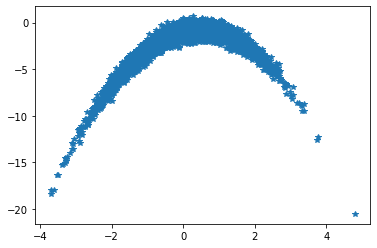

In [170]:
def proposal_rw_sampler(x, cov=1.0):
    """Sample from a random walk proposal with identity covariance"""
    sample_x = x.reshape(-1,1)
    cov_sqrt = scipy.linalg.sqrtm(cov)
    y = cov_sqrt @ np.random.randn(x.shape[0],1) + sample_x
    return y.reshape(1,-1)[0]

def proposal_rw_logpdf(x, y, cov=1.0):
    """Probability of moving from x to y (in this case it is symmetric)"""
    delta = (x.reshape(-1,1) - y.reshape(-1,1))
    logpdf = -0.5 * delta.T @ np.linalg.inv(cov) @ delta
    return logpdf[0,0]

def banana_sampler():      
    gauss_mean = np.array([0,0]).reshape(-1,1)
    cov = np.array([ [1, 0.9],[0.9, 1] ])
    cov_sqrt = scipy.linalg.sqrtm(cov)
    y = cov_sqrt @ np.random.randn(gauss_mean.shape[0],1)
    x1 = y[0,0]
    x2 = y[1,0] - 1 - x1**2    
    return np.array([x1,x2])

def banana_log_pdf(x):
    gauss_mean = np.array([0,0]).reshape(-1,1)
    cov = np.array([ [1, 0.9],[0.9, 1] ])
    cov_sqrt = scipy.linalg.sqrtm(cov)
    y1 = x[0]
    y2 = x[1] + 1 + x[0]**2
    y = np.array([y1, y2]).reshape(-1,1)
    
    d = y.shape[0]
    preexp = 1.0 / (2.0 * np.pi)**(d/2) / np.linalg.det(cov)**0.5
    exp = - 0.5 * y.T @ np.linalg.inv(cov) @ y
    out = np.log(preexp) + exp
    return out[0,0]
    
    

# proposal_rw_sampler(np.array([ [1],[2] ]), np.array( [ [1.0, 0.5],[0.5, 1.0] ] ))
# proposal_rw_logpdf(np.array([ 1,2 ]), np.array([0,0]), np.array( [ [1.0, 0.5],[0.5, 1.0] ] ))
#banana_sampler()
# Testing banana sampler
x = []
y = []
for i in range(10000):
    sample = banana_sampler()
    x.append(sample[0]); y.append(sample[1])
plt.plot(x,y,'*')

banana_log_pdf(np.array([1,2]))

In [132]:
def adaptive_mhmcmc(starting_sample, starting_cov, num_samples, target_logpdf, proposal_logpdf, proposal_sampler, adapt=False):
    """Metropolis-Hastings MCMC
    
    Inputs
    ------
    starting_sample: (d, ) the initial sample
    num_sample: positive integer, the number of total samples
    target_logpdf: function(x) -> logpdf of the target distribution
    proposal_logpdf: function (x, y) -> logpdf of proposing y if current sample is x
    proposal_sampler: function (x) -> y, generate a sample if you are currently at x
    
    Returns
    -------
    Samples: (num_samples, d) array of samples
    accept_ratio: ratio of proposed samples that were accepted
    """
    
    d = starting_sample.shape[0]
    samples = np.zeros((num_samples, d))
    cur_cov = starting_cov
    samples[0, :] = starting_sample
    current_target_logpdf = target_logpdf(samples[0, :])
    sample_mean = np.zeros(np.shape(starting_sample))
    
    num_accept = 0
    
    burn_in = 10
    burn_in_cov = 1000
    xi = 0.01
#     sd = 2.4**2/d
    sd = 2.4/d**2
    
    burn_in_sample = samples[0, :]
    
    # Throw away samples during burn in. Don't know if this really helps or not
    for ii in range(1, burn_in):
        # propose
        burn_in_sample = proposal_sampler(burn_in_sample, cur_cov)
        current_target_logpdf = target_logpdf(burn_in_sample)
        
    samples[0, :] = burn_in_sample
    
    cov_temp = cur_cov
    
    for ii in range(1, num_samples-burn_in):
        
        # Adapt covariance
        if adapt:
            if ii==burn_in_cov:
                cur_cov = cov_temp
                sample_mean, cur_cov = covariance_update(cur_cov, ii, samples[ii-1,:].reshape(-1,1), sample_mean.reshape(-1,1), sd, xi) # m for means
            elif ii>burn_in_cov:
                sample_mean, cur_cov = covariance_update(cur_cov, ii, samples[ii-1,:].reshape(-1,1), sample_mean.reshape(-1,1), sd, xi) # m for means
            elif ii>1:
                sample_mean = 1/(ii+1) *  samples[ii-1,:].reshape(-1,1) + ii/(ii+1) * sample_mean.reshape(-1,1)
                sample_mean, cov_temp = covariance_update(cov_temp, ii, samples[ii-1,:].reshape(-1,1), sample_mean.reshape(-1,1), sd, xi) # m for means
        
        # propose
        proposed_sample = proposal_sampler(samples[ii-1, :], cur_cov)
#         print("proposed", proposed_sample)
        proposed_target_logpdf = target_logpdf(proposed_sample)
                
        
        # determine acceptance probability
        proposal_logPDF = lambda x, y: proposal_logpdf(x, y, cur_cov)
        a = mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf, samples[ii-1,:], proposed_sample, proposal_logPDF)
        
        # Accept or reject the sample
        if a == 1: #guaranteed to accept
            samples[ii, :] = proposed_sample
            current_target_logpdf = proposed_target_logpdf
            num_accept += 1
        else:
            ## Accept with probability a
            u = np.random.rand()
            if u < a: # accept
                samples[ii, :] = proposed_sample
                current_target_logpdf = proposed_target_logpdf
                num_accept += 1
            else: # reject
                samples[ii, :] = samples[ii-1, :]
                
    return samples, num_accept / float(num_samples-1-burn_in)

Test Adaptive Metropolis

In [141]:
num_samples = 100000
dim = 2
initial_sample = np.random.randn(2) # random location
initial_covariance = np.array([ [1,0],[0,1] ])

# Adapt + False for MCMC
# Adapt = True for Adaptive Metropolis
samples, ar = adaptive_mhmcmc(initial_sample, initial_covariance, num_samples, banana_log_pdf, 
                     proposal_rw_logpdf, proposal_rw_sampler, adapt=False)

print("Accepted Samples Ratio:", ar)

Accepted Samples Ratio: 0.26000860094610406


### Histogram of samples

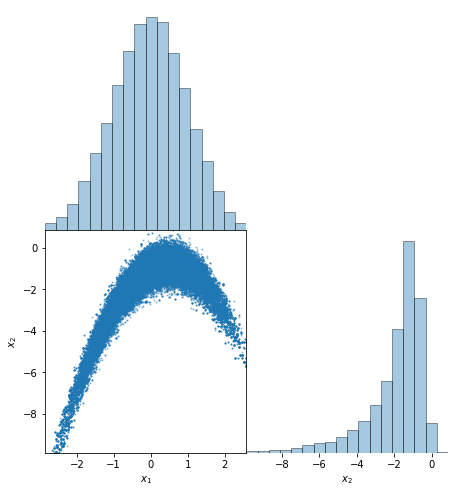

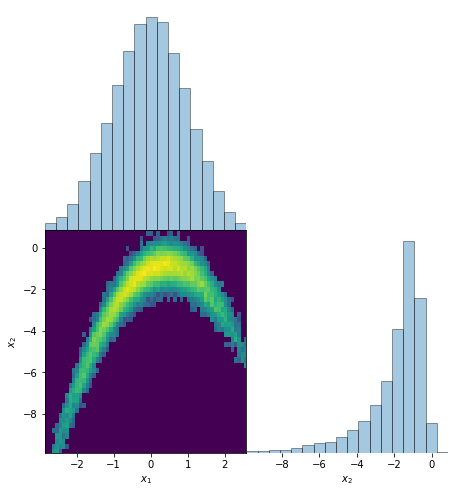

In [101]:
# plot samples from posterior
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=False, gamma=0.4)
fig.set_size_inches(7,7)
fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=True, gamma=0.2,
                                 nbins=70)
fig.set_size_inches(7,7)
plt.show()

### Samples with time -> should look like white noise

Text(0.5, 0, 'Sample Number')

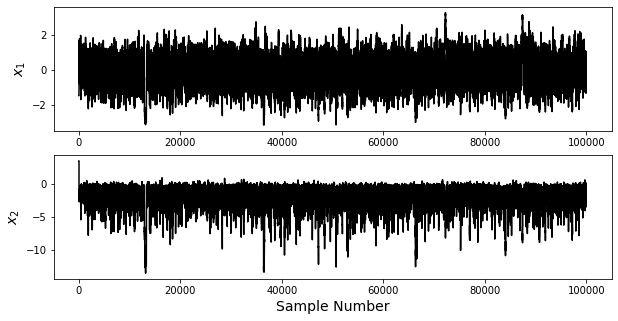

In [102]:
fig, axs = plt.subplots(2,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])

### Autocorrelation

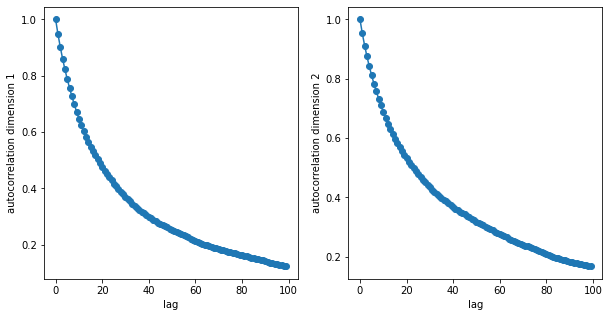

In [103]:
maxlag=100
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

## 1.2 Delayed Rejection Algorithm (working)

In [187]:
def delayed_rejection_mhmcmc(starting_sample, starting_cov, num_samples, target_logpdf, proposal_logpdf, proposal_sampler, adapt=False):
    """Metropolis-Hastings MCMC
    
    Inputs
    ------
    starting_sample: (d, ) the initial sample
    num_sample: positive integer, the number of total samples
    target_logpdf: function(x) -> logpdf of the target distribution
    proposal_logpdf: function (x, y) -> logpdf of proposing y if current sample is x
    proposal_sampler: function (x) -> y, generate a sample if you are currently at x
    
    Returns
    -------
    Samples: (num_samples, d) array of samples
    accept_ratio: ratio of proposed samples that were accepted
    """
    d = starting_sample.shape[0]
    burn_in = 10
    burn_in_cov = 10
    xi = 0.00001
    sd = 2.4**2/d
    sd = 2.4/d**2
    
    samples = np.zeros((num_samples-burn_in, d))
    cur_cov = starting_cov
    samples[0, :] = starting_sample
    current_target_logpdf = target_logpdf(samples[0, :])
    sample_mean = np.zeros(np.shape(starting_sample))
    
    num_accept = 0
    
    burn_in_sample = samples[0, :]
    
    # Throw away samples during burn in. Don't know if this really helps or not
    for ii in range(1, burn_in):
        # propose
        burn_in_sample = proposal_sampler(burn_in_sample, cur_cov)
        current_target_logpdf = target_logpdf(burn_in_sample)
        
    samples[0, :] = burn_in_sample
    
    cov_temp = cur_cov
    
    for ii in range(1, num_samples-burn_in):
        
        # Adapt covariance
        if adapt:
            if ii==burn_in_cov:
                cur_cov = cov_temp
                sample_mean, cur_cov = covariance_update(cur_cov, ii, samples[ii-1,:].reshape(-1,1), sample_mean.reshape(-1,1), sd, xi) # m for means
            elif ii>burn_in_cov:
                sample_mean, cur_cov = covariance_update(cur_cov, ii, samples[ii-1,:].reshape(-1,1), sample_mean.reshape(-1,1), sd, xi) # m for means
            elif ii>1:
                sample_mean = 1/(ii+1) *  samples[ii-1,:].reshape(-1,1) + ii/(ii+1) * sample_mean.reshape(-1,1)
                sample_mean, cov_temp = covariance_update(cov_temp, ii, samples[ii-1,:].reshape(-1,1), sample_mean.reshape(-1,1), sd, xi) # m for means
        
        
        # propose
        proposed_sample = proposal_sampler(samples[ii-1, :], cur_cov)
        proposed_target_logpdf = target_logpdf(proposed_sample)
                
        
        # determine acceptance probability
        proposal_logPDF = lambda x, y: proposal_logpdf(x, y, cur_cov)
        a = mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf, samples[ii-1,:], proposed_sample, proposal_logPDF)
        
        # Accept or reject the sample
        if a == 1: #guaranteed to accept
            samples[ii, :] = proposed_sample
            current_target_logpdf = proposed_target_logpdf
            num_accept += 1
        else:
            ## Accept with probability a
            u = np.random.rand()
            if u < a: # accept
                samples[ii, :] = proposed_sample
                current_target_logpdf = proposed_target_logpdf
                num_accept += 1
            else: # reject
                
                # Propose
                proposed2_sample = proposal_sampler(samples[ii-1, :], cur_cov/2)
                proposed2_target_logpdf = target_logpdf(proposed2_sample)
                
                # determine acceptance probability
                proposal2_logPDF = lambda x, y: proposal_logpdf(x, y, cur_cov/2)
                
                a1_1 = mh_acceptance_prob(proposed2_target_logpdf, proposed_target_logpdf, proposed2_sample, proposed_sample, proposal_logPDF)
                
                #remains same as above
                a1_2 = a # mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf, samples[ii-1,:], proposed_sample, proposal_logPDF)
                
                a2 = mh_acceptance_prob_2(current_target_logpdf, proposed2_target_logpdf, samples[ii-1,:], proposed_sample, proposed2_sample, proposal_logPDF, proposal2_logPDF, a1_1, a1_2)
                
                if a2 == 1: # accept sample 2
                    samples[ii, :] = proposed2_sample
                    current_target_logpdf = proposed2_target_logpdf
                    num_accept += 1
                else: # reject with some probability
                    u = np.random.rand()
                    if u<a2: # accept
                        samples[ii, :] = proposed2_sample
                        current_target_logpdf = proposed2_target_logpdf
                        num_accept += 1       
                    else:
                        samples[ii, :] = samples[ii-1, :]
                
    return samples, num_accept / float(num_samples-1)

In [188]:
num_samples = 10000
dim = 2
initial_sample = np.random.randn(2) # random location
initial_covariance = np.array([ [1,0],[0,1] ])

samples_dram, ar_dram = delayed_rejection_mhmcmc(initial_sample, initial_covariance, num_samples, banana_log_pdf, 
                     proposal_rw_logpdf, proposal_rw_sampler, adapt=True)

print("Accepted Samples Ratio:", ar_dram)

/home/hardik/Dropbox (University of Michigan)/Semesters/Semester 3/AEROSP 567 Inf Est & Learning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


Accepted Samples Ratio: 0.6593659365936594


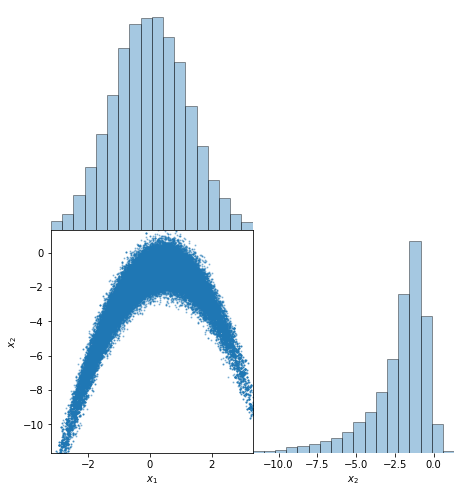

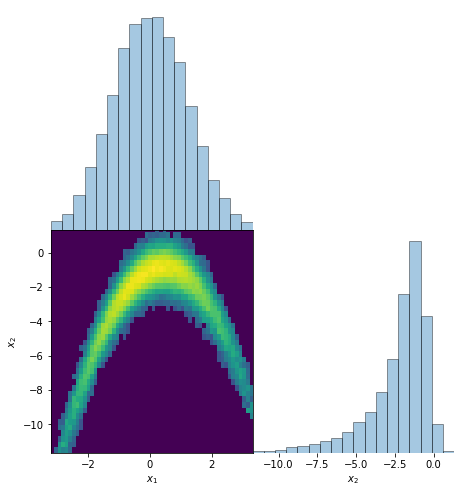

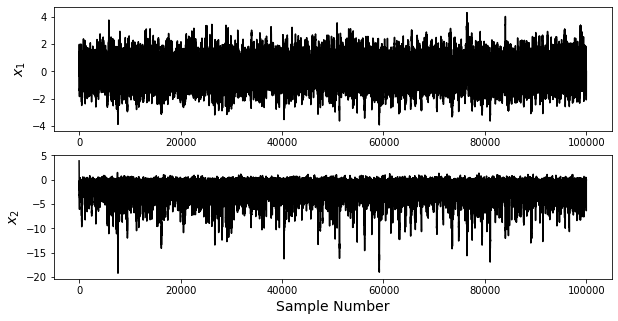

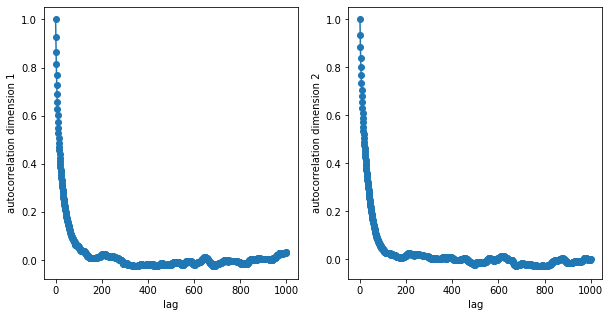

In [131]:
# plot samples from posterior
fig, axs, gs = scatter_matrix([samples_dram], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=False, gamma=0.4)
fig.set_size_inches(7,7)
fig, axs, gs = scatter_matrix([samples_dram], labels=[r'$x_1$', r'$x_2$'], 
                              hist_plot=True, gamma=0.2,
                                 nbins=70)
fig.set_size_inches(7,7)
plt.show()

## Samples with time -> should look like white noise
fig, axs = plt.subplots(2,1, figsize=(10,5))
axs[0].plot(samples_dram[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples_dram[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])

## Autocorrelation
maxlag=1000
step=1
lags, autolag = autocorrelation(samples_dram, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

# 2. Setting up truth model for a deterministic system

### Identifiable Version

In [155]:
theta = np.array([0.02, 0.6, 0.15])
def SIR(t, y, theta):
    S = y[0]; I = y[1]; R = y[2];
    beta = theta[0]; r = theta[1]; delta = theta[2];
    N = 1000
    dS = delta*N - delta*S -beta*I*S
    dI = beta*I*S - (r+delta)*I
    dR = r*I - delta*R
    return np.array([dS,dI,dR])
SIR_theta = lambda t, y: SIR(t, y, theta)
sol = scipy.integrate.solve_ivp(SIR_theta, [0,6], np.array([900,100,0]), t_eval = np.linspace(0,6,61), method='RK45')

In [156]:
# sol

Text(0, 0.5, 'R')

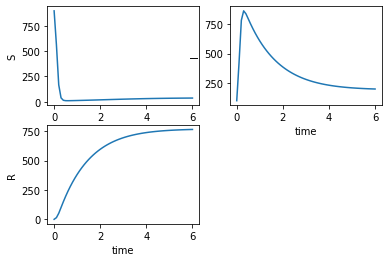

In [157]:
plt.subplot(221)
plt.plot(sol.t, sol.y[0,:])
plt.xlabel('time')
plt.ylabel('S')

plt.subplot(222)
plt.plot(sol.t, sol.y[1,:])
plt.xlabel('time')
plt.ylabel('I')

plt.subplot(223)
plt.plot(sol.t, sol.y[2,:])
plt.xlabel('time')
plt.ylabel('R')


In [158]:
I = sol.y[1,:]
std_dev = 50
I_DATA = I + std_dev*np.random.randn(np.shape(I)[0])

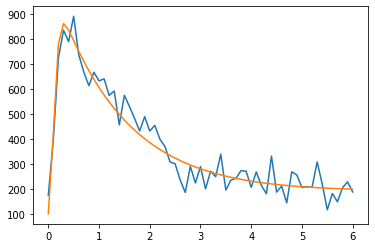

In [159]:
plt.plot(sol.t,I_DATA)
plt.plot(sol.t,I)

### Non-Identifiable Version

In [146]:
theta_NI = np.array([0.2,0.1,0.6,0.15])
def SIR_NI(t, y, theta):
    S = y[0]; I = y[1]; R = y[2];
    gamma = theta[0]; k = theta[1]; r = theta[2]; delta = theta[3];
    N = 1000
    dS = delta*N - delta*S - gamma*k*I*S
    dI = gamma*k*I*S - (r+delta)*I
    dR = r*I - delta*R
    return np.array([dS,dI,dR])
SIR_theta_NI = lambda t, y: SIR_NI(t, y, theta_NI)
sol_NI = scipy.integrate.solve_ivp(SIR_theta_NI, [0,6], np.array([900,100,0]), t_eval = np.linspace(0,6,61), method='RK45')

Text(0, 0.5, 'R')

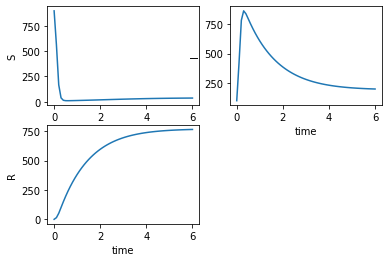

In [147]:
plt.subplot(221)
plt.plot(sol_NI.t, sol_NI.y[0,:])
plt.xlabel('time')
plt.ylabel('S')

plt.subplot(222)
plt.plot(sol_NI.t, sol_NI.y[1,:])
plt.xlabel('time')
plt.ylabel('I')

plt.subplot(223)
plt.plot(sol_NI.t, sol_NI.y[2,:])
plt.xlabel('time')
plt.ylabel('R')

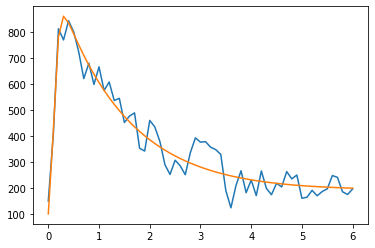

In [148]:
I_NI = sol_NI.y[1,:]
std_dev = 50
I_DATA_NI = I_NI + std_dev*np.random.randn(np.shape(I_NI)[0])
plt.plot(sol_NI.t,I_DATA_NI)
plt.plot(sol_NI.t,I_NI)

# 3. Bayesian Inference

In [168]:
def gaussian_logpdf(x, y, std_dev=1.0):
    """Probability of x given y """
    delta = (x.reshape(-1,1) - y.reshape(-1,1))
    cov_inv = 1/std_dev/std_dev * np.eye( np.shape(y)[0] )
    logpdf = -0.5 * delta.T @ cov_inv @ delta
    return logpdf[0,0]

       
def target_loglikelihood(theta, y):
    # prior x likelihood
    
    # likelihood calculation
    SIR_theta = lambda t, y: SIR(t, y, theta)
    sol = scipy.integrate.solve_ivp(SIR_theta, [0,6], np.array([900,100,0]), t_eval = np.linspace(0,6,61), method='RK45')
    log_likelihood = gaussian_logpdf(y, sol.y[1,:], std_dev = 50 )
    
    return  gaussian_logpdf( theta, np.array([0,0,0]), std_dev=1 ) + log_likelihood


        

In [174]:
num_samples = 1000
dim = 3
initial_sample = np.random.randn(3) # random location
initial_covariance = np.eye(3)

target_loglikelihood_theta = lambda x: target_loglikelihood(x, I_DATA)

samples, ar = delayed_rejection_mhmcmc(initial_sample, initial_covariance, num_samples, target_loglikelihood_theta, 
                     proposal_rw_logpdf, proposal_rw_sampler, adapt=True)

print("Accepted Samples Ratio:", ar)

/home/hardik/Dropbox (University of Michigan)/Semesters/Semester 3/AEROSP 567 Inf Est & Learning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


Accepted Samples Ratio: 0.13513513513513514


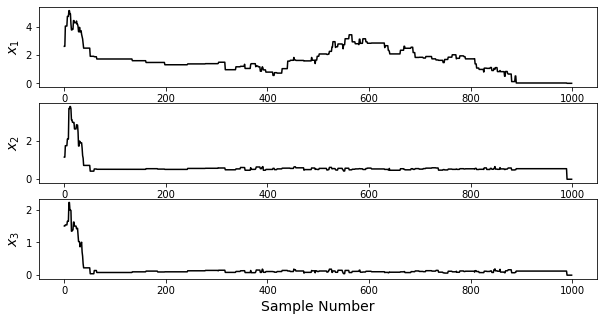

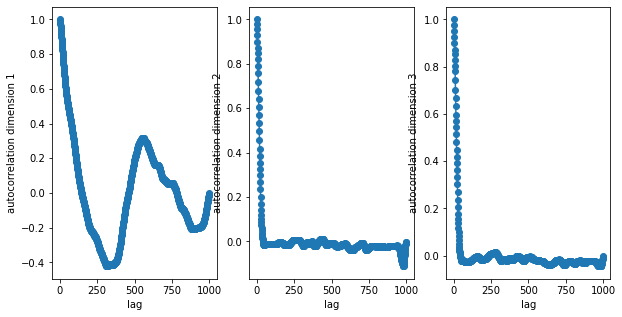

In [179]:
# plot samples from posterior
# fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
#                               hist_plot=False, gamma=0.4)
# fig.set_size_inches(7,7)
# fig, axs, gs = scatter_matrix([samples], labels=[r'$x_1$', r'$x_2$'], 
#                               hist_plot=True, gamma=0.2,
#                                  nbins=70)
# fig.set_size_inches(7,7)
# plt.show()

## Samples with time -> should look like white noise
fig, axs = plt.subplots(3,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
axs[2].plot(samples[:, 2], '-k')
axs[2].set_ylabel(r'$x_3$', fontsize=14)
axs[2].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])

## Autocorrelation
maxlag=1000
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
axs[2].plot(lags, autolag[:, 2],'-o')
axs[2].set_xlabel('lag')
axs[2].set_ylabel('autocorrelation dimension 3')
plt.show()


In [189]:
print(np.shape(samples))
samples[-20:-1,:]  # ignore zeros below in output. array was initialzed to wrong size

(1000, 3)


array([[0.02224647, 0.54660162, 0.12477175],
       [0.02224647, 0.54660162, 0.12477175],
       [0.02224647, 0.54660162, 0.12477175],
       [0.02224647, 0.54660162, 0.12477175],
       [0.02224647, 0.54660162, 0.12477175],
       [0.02224647, 0.54660162, 0.12477175],
       [0.02224647, 0.54660162, 0.12477175],
       [0.02224647, 0.54660162, 0.12477175],
       [0.02224647, 0.54660162, 0.12477175],
       [0.02224647, 0.54660162, 0.12477175],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

### Non-identifiable system

In [ ]:
def target_loglikelihood_NI(theta, y):
    # prior x likelihood
    
    # likelihood calculation
    SIR_theta = lambda t, y: SIR_NI(t, y, theta)
    sol = scipy.integrate.solve_ivp(SIR_theta, [0,6], np.array([900,100,0]), t_eval = np.linspace(0,6,61), method='RK45')
    log_likelihood = gaussian_logpdf(y, sol.y[1,:], std_dev = 50 )
    
    return  gaussian_logpdf( theta, np.array([0,0,0,0]), std_dev=1 ) + log_likelihood

num_samples = 1000
dim = 3
initial_sample = np.random.randn(4) # random location
initial_covariance = np.eye(4)

target_loglikelihood_theta = lambda x: target_loglikelihood_NI(x, I_DATA_NI)

samples_q3_ni, ar_q3_ni = delayed_rejection_mhmcmc(initial_sample, initial_covariance, num_samples, target_loglikelihood_theta, 
                     proposal_rw_logpdf, proposal_rw_sampler, adapt=True)

print("Accepted Samples Ratio:", ar)

In [ ]:
def laplace_approx(initial_guess, logpost):
    """ Perform the laplace approximation
    
    Inputs
    -------
    initial_guess: (p, ) array of parameter guesses
    logpost: callable (p) to a scalar, denoting the posterior
    
    Output
    ------
    map_point: (p, )
    covariance: inverse hessian    
    """
    
    def neglogpost(params):
        return -logpost(params)
    
    # Gradient free method to obtain close to optimum
    res = scipy.optimize.minimize(neglogpost, initial_guess, method='Nelder-Mead')
    
    # Gradient based method to approximate hessian
    res = scipy.optimize.minimize(neglogpost, res.x)
    
    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

guess_g = np.random.randn(num_params_g)
map_point, cov_laplace = laplace_approx(guess_g, logpost_g)
map_point